In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf

In [451]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset and Select Ticker

In [470]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
tsla_df = stock_df[stock_filt]
tsla_df = clean_stock_data(tsla_df)
window = 30
tsla_df['moving_max'] = moving_max(tsla_df, days=window)
tsla_df['moving_min'] = moving_min(tsla_df, days=window)
tsla_df['moving_avg_volume'] = moving_avg_volume(tsla_df, days=window)
tsla_df['moving_avg_HL'] = moving_avg_HL(tsla_df, days=window)
tsla_df.head()

,date,open,high,low,close,adj_close,volume,stock_name,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,258.493347,258.493347,53868000.0,4.709991
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,258.493347,258.406677,52481100.0,5.220001
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,260.510010,258.406677,65470700.0,6.907776
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,260.510010,258.406677,62927475.0,7.106659
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,260.916656,258.406677,59121660.0,6.581329


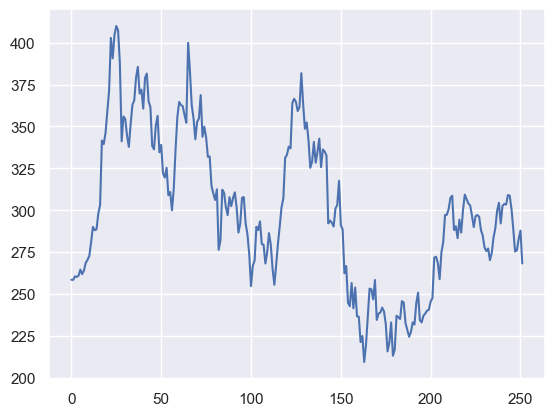

In [471]:
plt.plot(tsla_df['close'].values)

### Generate Useful Features

In [472]:
features = pd.DataFrame()
#normalize close, volume wrt moving min/max
features['close'] = normalize_close(tsla_df)
features['volume'] = normalize_volume(tsla_df)
features['day_HL'] = normalize_HL(tsla_df)
features['sma'] = simple_moving_average(features)
features['ema'] = exponential_moving_average(features)
features['rsi'] = calculate_rsi(features)/10
features['macd_line'] , features['macd_signal'], features['macd_histogram'] = calculate_macd(features)
features['bb_middle'], features['bb_upper'], features['bb_lower'] = bollinger_bands(features)
features['target'] = calculate_closing_diff(features)

#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower,target
30,0.634036,-0.225144,1.205485,0.922112,0.820391,2.659657,0.028582,0.104261,-0.075679,0.922112,1.205396,0.638828,-0.009765
31,0.562695,-0.123877,0.834094,0.900247,0.795848,2.437266,0.006179,0.084645,-0.078465,0.900247,1.222978,0.577515,-0.071342
32,0.518116,0.185585,1.239311,0.876152,0.769398,2.384661,-0.014999,0.064716,-0.079715,0.876152,1.237204,0.515101,-0.044578
33,0.608239,-0.103368,1.246601,0.859642,0.754049,2.908123,-0.024231,0.046927,-0.071158,0.859642,1.238461,0.480822,0.090122
34,0.682958,0.042524,1.399640,0.846061,0.747279,3.432200,-0.025228,0.032496,-0.057723,0.846061,1.229990,0.462131,0.074719


### Generate GRU train and test split

In [473]:
target = -1 #predict closing delta
#target = 0 #predict closing
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))

test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (201, 20, 13)
> Data y: (201,)
Train Set
> Data X: (171, 20, 13)
> Data y: (171,)
Test Set
> Data X: (30, 20, 13)
> Data y: (30,)


### Define Model

In [475]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [476]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=1, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0170  


In [477]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=100,
    batch_size=128
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0157 - val_loss: 0.5478
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4261 - val_loss: 0.0445
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0363 - val_loss: 0.1724
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1315 - val_loss: 0.0631
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0499 - val_loss: 0.0211
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0158 - val_loss: 0.0720
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0501 - val_loss: 0.0728
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0495 - val_loss: 0.0372
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0246 - val_loss: 0.0191
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0146 - val_loss: 0.0249
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0224 - val_loss: 0.0336
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0307 - val_los

### Plot Performance

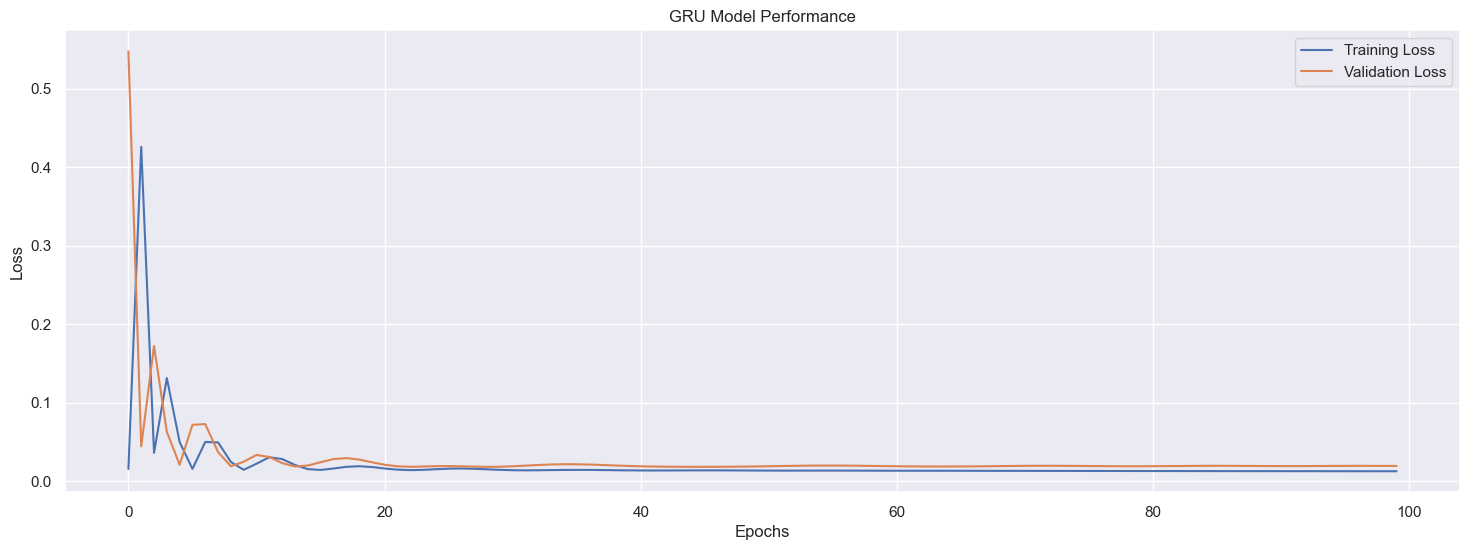

In [478]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


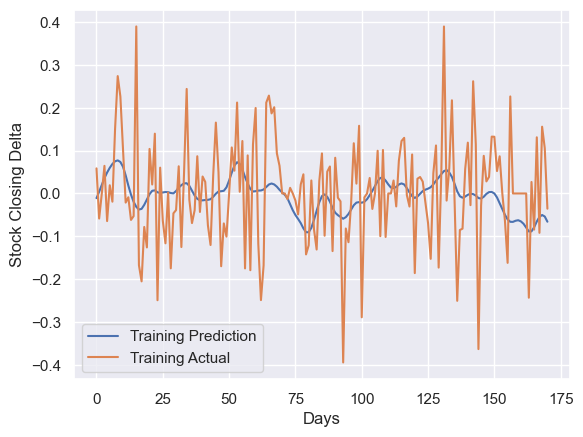

In [479]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions, label='Training Prediction')
plt.plot(train_actual, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Stock Closing Delta')
plt.legend()

In [514]:
diff = np.sign(train_predictions.flatten())-np.sign(train_actual.flatten())
thresh = 0.02
significant = np.where(np.abs(train_predictions.flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')

We perform predictions for 171 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 0.02
There are 87 such events
Of those events, we predict 36 incorrectly


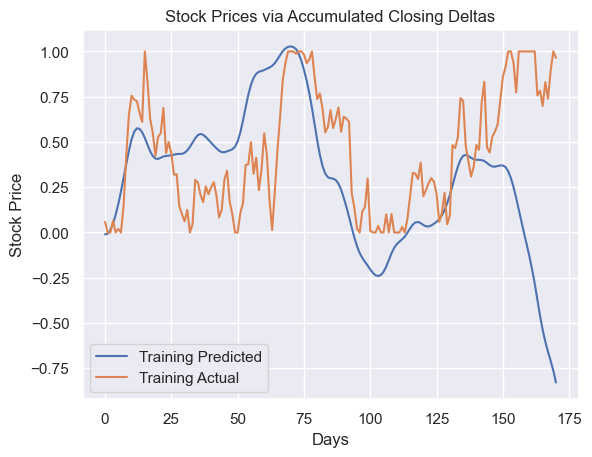

In [480]:
stock_price_train_pred = np.cumsum(train_predictions)
stock_price_train_actual = np.cumsum(train_actual)
plt.plot(stock_price_train_pred, label='Training Predicted')
plt.plot(stock_price_train_actual, label='Training Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


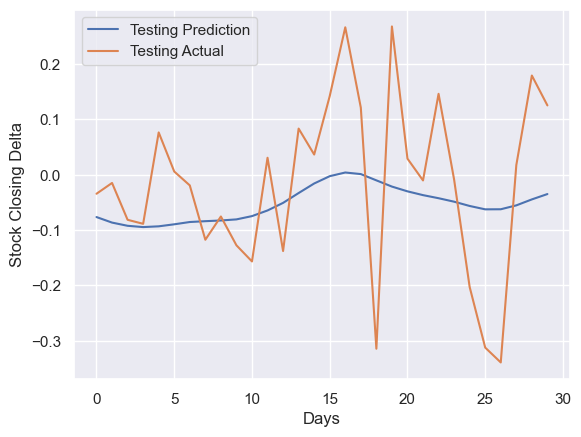

In [465]:
test_predictions = mymodel.predict(datax_test)
test_actual = datay_test
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(test_actual, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Stock Closing Delta')
plt.legend()

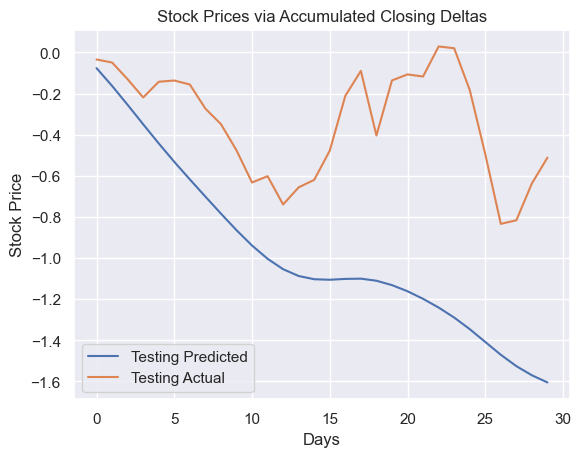

In [468]:
stock_price_test_pred = np.cumsum(test_predictions)
stock_price_test_actual = np.cumsum(test_actual)
plt.plot(stock_price_test_pred, label='Testing Predicted')
plt.plot(stock_price_test_actual, label='Testing Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()